In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

### Подготовка данных и модели

Определим функцию, создающие последовательности X и Y заданной длины, и функцию, записывающую заданное количество таких последовательностей в датасет.
Проверим правильность работы

In [2]:
def sequence(length):
    x = torch.randint(0, 9, [length], dtype=torch.long)
    y = torch.zeros(length, dtype=torch.long)
    y[0] = x[0]
    for i in range(1, len(y)):
        y[i] = (x[i] + x[0]) % 10
    return tuple([x, y])

def create_data(sequence_num, sequence_length):
    return [sequence(sequence_length) for i in range(sequence_num)]

In [3]:
create_data(2, 3)

[(tensor([8, 4, 6]), tensor([8, 2, 4])),
 (tensor([8, 2, 0]), tensor([8, 0, 8]))]

Определим класс нейросетевой модели. Будем использовать простую модель эмбеддинг - рекурентная ячейка - линейный слой. Будем использовать небольшую размерность эмбеддинга, так как исходные классы несложные, их близость неважна. Размер скрытого состояния подберём таким, чтобы разница между итоговыми моделями была видна. 

In [4]:
class Network(torch.nn.Module):
    def __init__(self, rnnClass):
        super().__init__()

        self.embedding = torch.nn.Embedding(10, 16)
        self.rnn = rnnClass(16, 80, batch_first=True)
        self.head = torch.nn.Linear(80, 10)
        
    def forward(self, X):
        out = self.embedding(X)
        o, s = self.rnn(out)
        out = self.head(o)
        return out

criterion = torch.nn.CrossEntropyLoss()

Проверим размерности данных на каждом слое, небольшое количество параметров соответствуют простым данным

In [13]:
model_rnn = Network(torch.nn.RNN)
Data_Train_25 = create_data(50, 25)
Train_25 = torch.utils.data.DataLoader(Data_Train_25, batch_size=50)
summary(model_rnn, next(iter(Train_25))[0].shape, dtypes=['torch.IntTensor'], device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [50, 25, 10]              --
├─Embedding: 1-1                         [50, 25, 16]              160
├─RNN: 1-2                               [50, 25, 80]              7,840
├─Linear: 1-3                            [50, 25, 10]              810
Total params: 8,810
Trainable params: 8,810
Non-trainable params: 0
Total mult-adds (M): 9.85
Input size (MB): 0.01
Forward/backward pass size (MB): 1.06
Params size (MB): 0.04
Estimated Total Size (MB): 1.10

Определяем функцию обучения модели. Добавляем возможности логирования результатов по эпохам и построения графников

In [6]:
def train(rnn, train, test, label, epoch_num=25, verbose=False, plot=True):

    model = Network(rnn)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    
    hist_train = np.empty(epoch_num)
    hist_test = np.empty(epoch_num)
    acc_train = np.empty(epoch_num)
    acc_test = np.empty(epoch_num)
    
    for i in range(epoch_num):
        
        model.train()
        hist_train_epoch = 0
        acc_train_epoch = 0
        for X, Y in train:      
            optimizer.zero_grad()
            Y_pred = model(X)
            loss = criterion(Y_pred.mT, Y)
            loss.backward()
            optimizer.step()
            
            hist_train_epoch += loss.item()
            acc_train_epoch += (torch.argmax(Y_pred, dim=2) == Y).sum().item() / torch.numel(Y)

        model.eval()
        hist_test_epoch = 0
        acc_test_epoch = 0
        for X, Y in test:
            Y_pred = model(X)
            loss = criterion(Y_pred.mT, Y)

            hist_test_epoch += loss.item()
            acc_test_epoch += (torch.argmax(Y_pred, dim=2) == Y).sum().item() / torch.numel(Y)

        hist_train[i] = hist_train_epoch/len(train)
        hist_test[i] = hist_test_epoch/len(test)
        acc_train[i] = acc_train_epoch/len(train)*100
        acc_test[i] = acc_test_epoch/len(test)*100

        if verbose:
            if (i+1) % verbose == 0:
                print(f"Пройдена эпоха {i+1} из {epoch_num}, результаты:")
                print(f"Loss Train / Test: {hist_train[i]} / {hist_test[i]}")
                print(f"Accuracy Train / Test: {acc_train[i]}% / {acc_test[i]}%")

    if plot:
        plt.figure(figsize=(16, 6))
        
        plt.subplot(1, 3, 2)
        plt.plot(hist_test, label=f"Loss test {label}")
        plt.plot(hist_train, label=f"Loss train {label}")
        plt.grid()
        plt.legend()
        
        plt.subplot(1, 3, 3)
        plt.plot(acc_test, label=f"% Acc test {label}")
        plt.plot(acc_train, label=f"% Acc train {label}")
        plt.grid()
        plt.legend()

    model.eval()
    num_elements = 0
    miss_over_time = 0
    for X, Y in test:
        Y_pred = model(X)        
        miss_over_time += (torch.argmax(Y_pred, dim=2) != Y).sum(0)
        num_elements += len(Y)

    miss_over_time = (miss_over_time / num_elements * 100).numpy()
    plt.subplot(1, 3, 1)
    plt.plot(miss_over_time, label=f"% Miss {label}")
    plt.grid()
    plt.legend()
    plt.show()

    return miss_over_time

In [7]:
RNN_to_test = [torch.nn.RNN, torch.nn.LSTM, torch.nn.GRU]
RNN_labels = ['RNN', 'LSTM', 'GRU']
Batch_size = 50

# train(model_rnn, criterion, optimizer_RNN, Train_25, Test_25, verbose=1, epoch_num=40)

### Результаты работы на последовательностях из 25 элементов

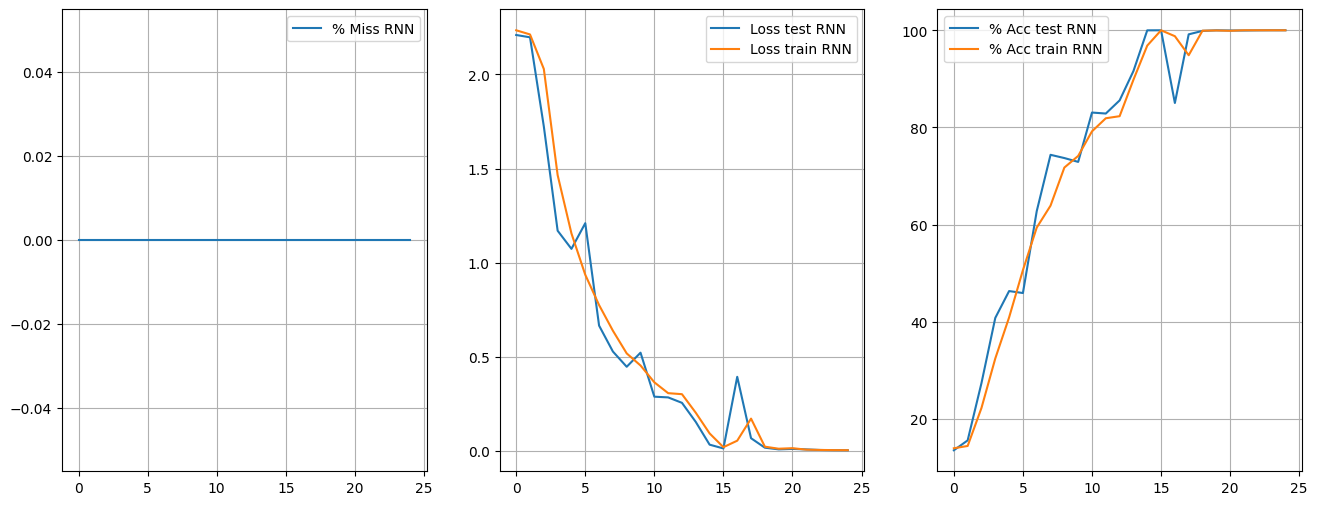

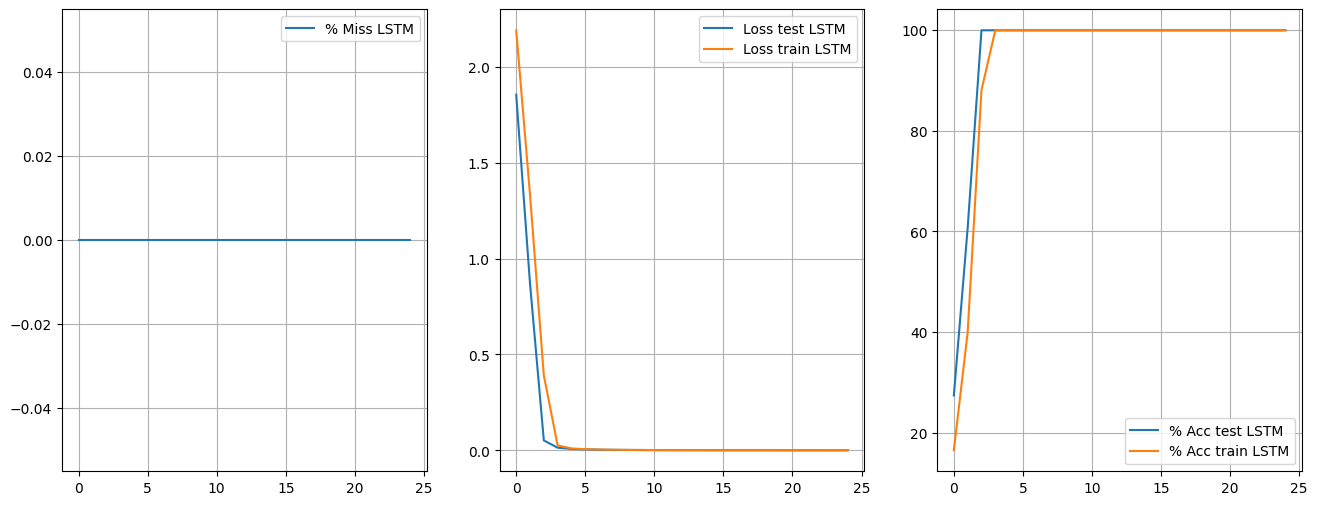

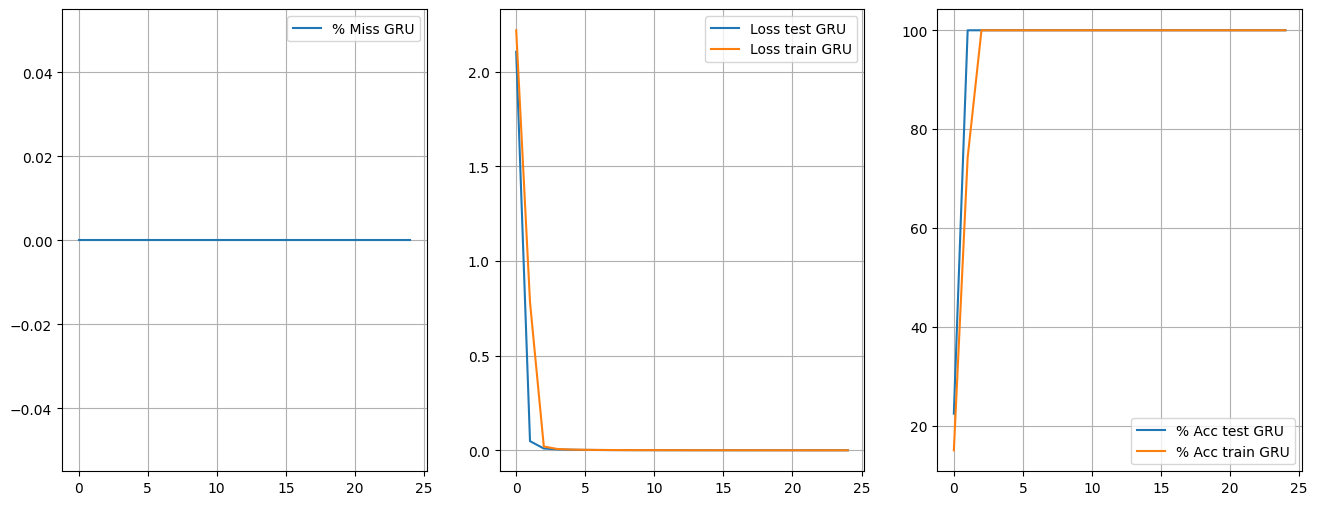

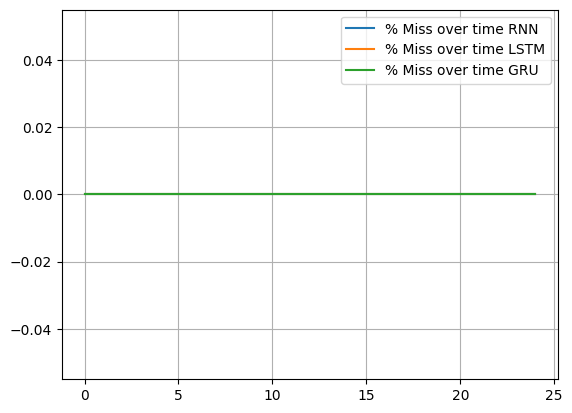

In [8]:
Data_Train_25 = create_data(5000, 25)
Data_Test_25 = create_data(1000, 25)
Train_25 = torch.utils.data.DataLoader(Data_Train_25, batch_size=Batch_size)
Test_25 = torch.utils.data.DataLoader(Data_Test_25, batch_size=Batch_size)

miss_25 = np.empty((25, 3))

for i, rnn in enumerate(RNN_to_test):
    miss_25[:, i] = train(rnn, Train_25, Test_25, RNN_labels[i])    

plt.plot(miss_25)
label=[f"% Miss over time {name}" for name in RNN_labels]
plt.legend(label)
plt.grid()
plt.show()

### Результаты работы на последовательностях из 75 элементов

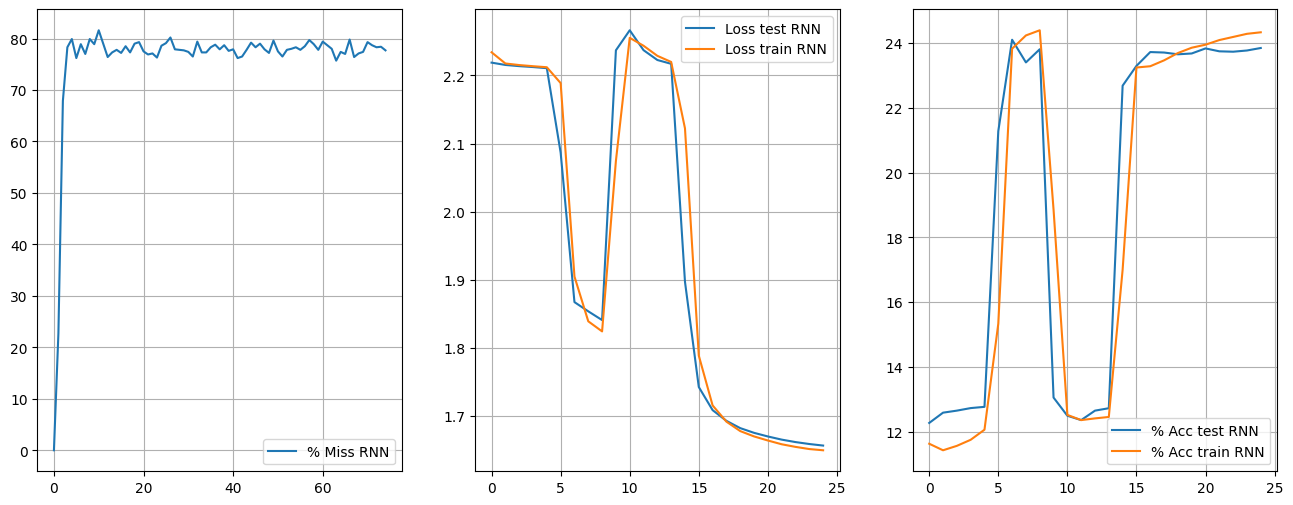

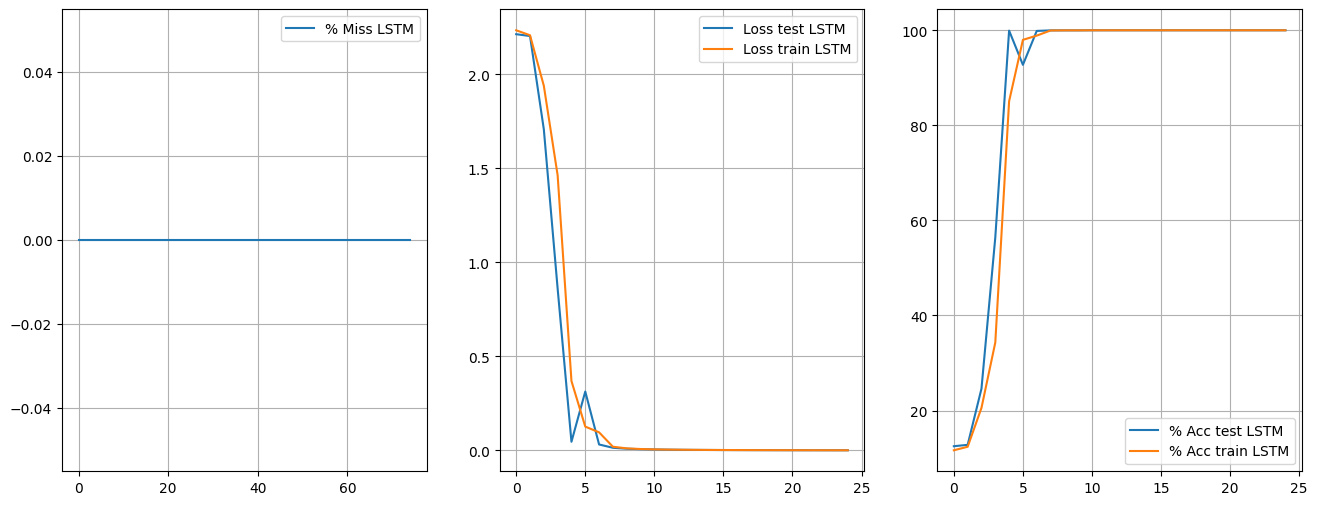

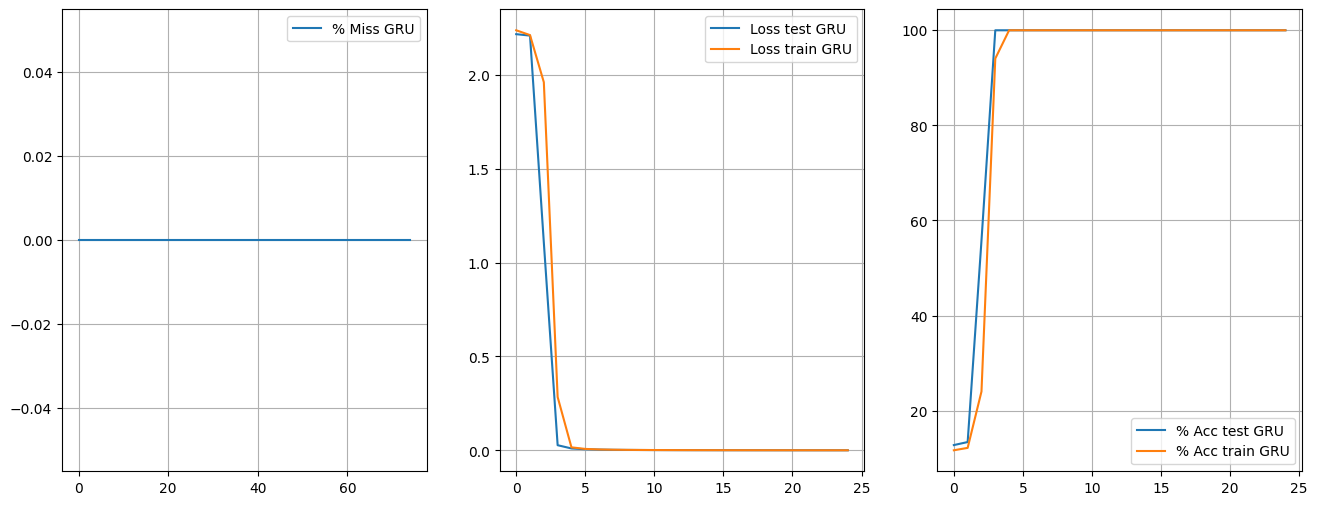

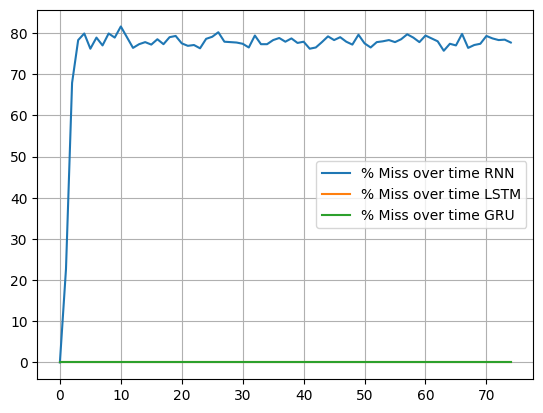

In [9]:
Data_Train_75 = create_data(5000, 75)
Data_Test_75 = create_data(1000, 75)
Train_75 = torch.utils.data.DataLoader(Data_Train_75, batch_size=Batch_size)
Test_75 = torch.utils.data.DataLoader(Data_Test_75, batch_size=Batch_size)

miss_75 = np.empty((75, 3))

for i, rnn in enumerate(RNN_to_test):
    miss_75[:, i] = train(rnn, Train_75, Test_75, RNN_labels[i])

plt.plot(miss_75)
label=[f"% Miss over time {name}" for name in RNN_labels]
plt.legend(label)
plt.grid()
plt.show()

### Результаты работы на последовательностях из 250 элементов

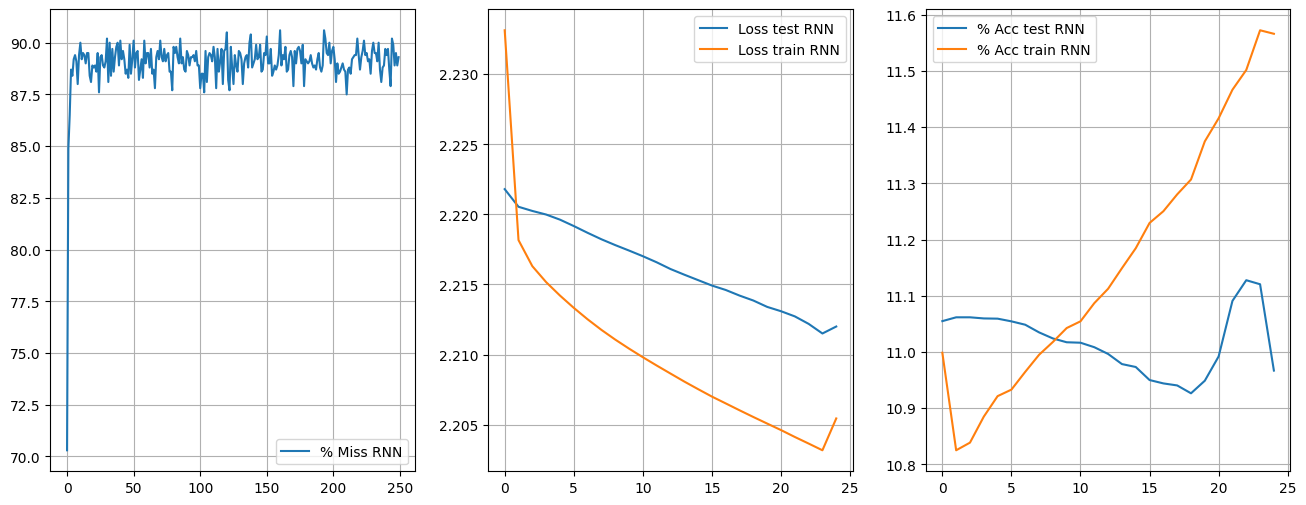

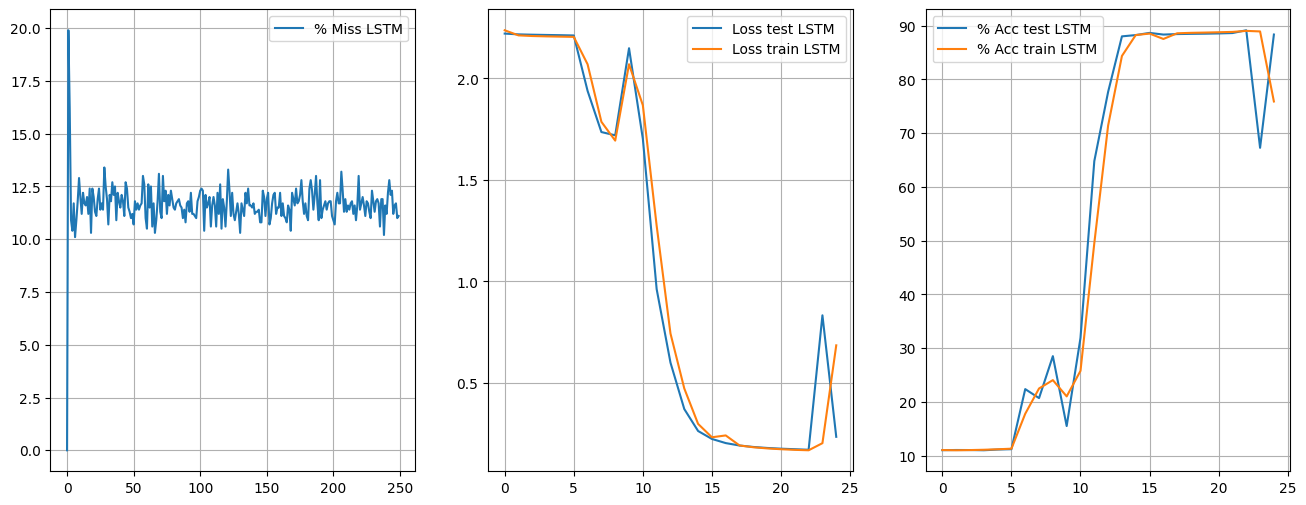

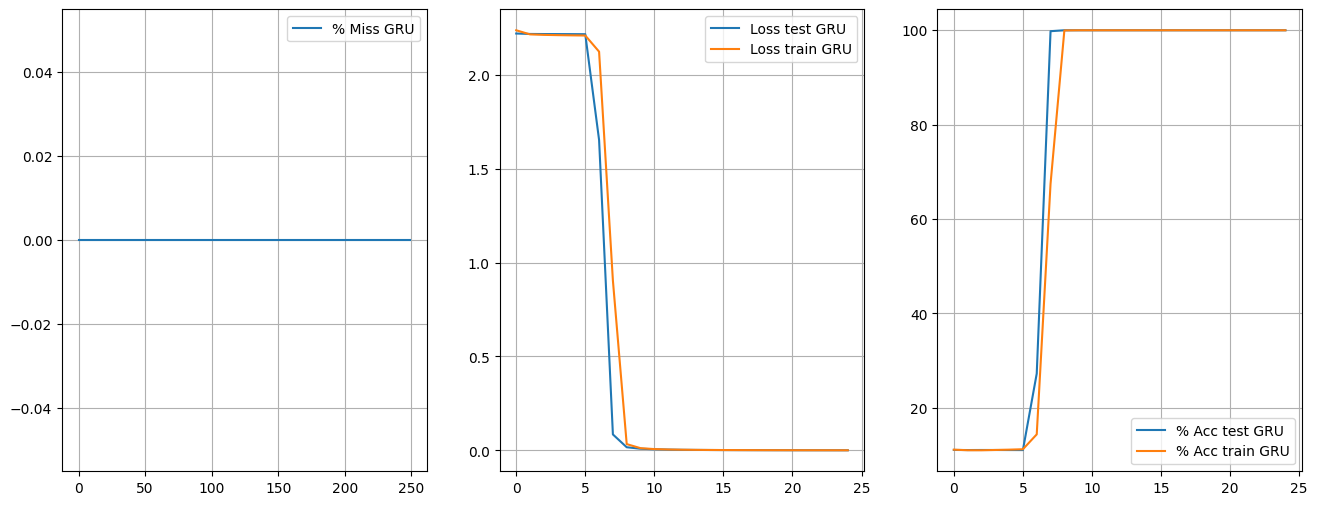

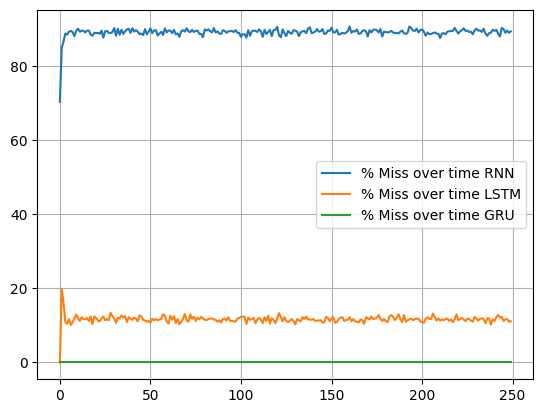

In [10]:
Data_Train_250 = create_data(5000, 250)
Data_Test_250 = create_data(1000, 250)
Train_250 = torch.utils.data.DataLoader(Data_Train_250, batch_size=Batch_size)
Test_250 = torch.utils.data.DataLoader(Data_Test_250, batch_size=Batch_size)

miss_250 = np.empty((250, 3))

for i, rnn in enumerate(RNN_to_test):
    miss_250[:, i] = train(rnn, Train_250, Test_250, RNN_labels[i])

plt.plot(miss_250)
label=[f"% Miss over time {name}" for name in RNN_labels]
plt.legend(label)
plt.grid()
plt.show()

### Итоги

Полученые результаты показывают, что при одинаковой размерности скрытого состояния базовая RNN ячейка показывает значительно худшие результаты. Уже при рассмотрении последовательности 75 элементов модель оказывается едва ли рабоспособной (точность 20% по сравнению с 10% при случайном выборе элемента). Данные результаты можено объяснить простотой модели и малым количеством параметров

Интересным результатом является лучшая работа GRU ячейки по сравнению с LSTM. Интерес представляет тот факт, что не смотря на меньшее количество параметров (30к - LSTM, 20к - GRU), качество работы GRU оказалось выше для длинной последоватлеьности.